In [10]:
# notebook I've been working on 6/10
# load dependencies
import joblib
import os
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import rioxarray as rxr
import datetime
import geopandas as gpd

from working_sca_funcs import create_binary_chm
import xarray as xr

## SET USER DEFINITIONS

In [11]:
# location of the Planet data
focus_year = 2022
name = 'DLNY'
model = 'base'
# processed_direc = f'/data0/images/planet/emma/planet/processed_SCA/{name}/{model}/'
processed_direc = f'/home/etboud/projects/data/temp/{name}/{model}/'
data_direc = f'/data0/images/planet/emma/planet/{name}/'
# data_direc = f'/home/etboud/projects/data/planet/{name}/'

# specify if the output snow cover maps should be saved or not (1 = save, 0 = do not save)
saveData = 1

# specify the model used to classify snow presence, snow absence, and artifacts
model = joblib.load(f'/home/etboud/projects/data/training_data/3class_model_2022_{model}.joblib')

# model_can = joblib.load(f'/home/etboud/projects/data/training_data/3class_model_2022_canopy_composite.joblib')
# model_open = joblib.load(f'/home/etboud/projects/data/training_data/3class_model_2022_open_composite.joblib')


# specify the directories and the indices of which PS scenes to filter, if any
subdirecs = sorted([d for d in glob.glob(data_direc + str(focus_year) + '*') if os.path.isdir(d)])
# filtered_scenes = [10,18,27,35,36,38,40,41,44,45,48,50,51,79,96] # 2023, DLNY
# filtered_scenes = [10,11,24,43,47,50,52,56,63,64,67,81,82,83,85,95,97,100,104,108] #2022,DLNY
# filtered_scenes  = [2,3,4,9,10,11,14,15,18,19,22,24,28,29,30,33,39,51,52] #2023, DNBC (forgot to run this though)
# filtered_scenes = [4,5,8,9,11,14,16,20,23,29,30,33,37,48,51,74,83,85] # 2023, LYMC
# filtered_scenes  = [0,2,3,6,7,9,10,14,16,18,20,21,13,20,34,35,37,39,41,43,45,64,70,75,87,94,98] #2023, BUDD
# filtered_scenes = [0,1,2,4,7,8,9,11,12,13,14,17,18,19,21,22,23,25,26,26,28,29,32,33,36,38,41,42,50,52,56,59,61,66,68,70,75,76,83,89,98,100,111,113,115,118,119,121,122] # BUDD,2022
# filtered_scenes = [0,3,4,7,8] #2023, LYTB
# filtered_scenes = [0,1,7,9,24,26] # 2022, LYMC (not all of 2022 only up to 5/24)
# filtered_scenes = [0,1,2,6,7,9,10,11,14] # 2020, LYMC
# filtered_scenes = [8,9,11,12,13,15,17,18,20,22,25,28,33,36,37,38,39,42,45,50,51,54,55,56,57,58,59,65,69,70,71,72,73,74,75,76,77,78,79,81,87,95,99,102,105,108,109,116,125,126,127,129,136] # 2020, BUDD
# filtered_scenes = [8,11,12,13,15,16,18,20,22,28,28,33,36,37,38,39,42,45,50,51,54,55,58,59,64,70,72,73,74,75,77,78,79,81,87,95,99,101,102,105,108,115,116,121,122,126,127]
#filtered_scenes = []
# print(subdirecs)

# reference file containing the maximum extents
ref_file = data_direc+'20230609_175435_13_242e/25d3618d-2f37-4c9e-8d67-c10e9d477081/PSScene/20230609_175435_13_242e_3B_AnalyticMS_SR_clip.tif' # DLNY
# ref_file = data_direc+'20230408_182628_56_241c/7a22bb8c-db55-48ff-9331-de88efeb7c6b/PSScene/20230408_182628_56_241c_3B_AnalyticMS_SR_clip.tif' # DNBC
# ref_file = data_direc+'20230625_175258_51_24d0/21bbfe1d-6c68-4fda-81eb-294e897980c0/PSScene/20230625_175258_51_24d0_3B_AnalyticMS_SR_clip.tif' # LYMC
# ref_file = f'/data0/images/planet/emma/planet/{name}/' + '20230423_175100_99_242e/a514a5df-5610-45c4-8498-a774361cb492/PSScene/20230423_175100_99_242e_3B_AnalyticMS_SR_clip.tif' # BUDD
# ref_file = data_direc+'20230425_175239_90_24b2/64f394c8-999f-4cb8-8aa7-86421c5ecaa4/PSScene/20230425_175239_90_24b2_3B_AnalyticMS_SR_clip.tif' # LYTB
# ref_file  = data_direc + '20220403_174654_26_2451/68f7d4a5-cb41-4b0b-b0bb-1ce016f66730/PSScene/20220403_174654_26_2451_3B_AnalyticMS_SR_clip.tif' # BUDD rec
# ref_file = data_direc + '20220609_173032_58_249d/6f0dba90-e90f-490d-936d-28c482343d1e/PSScene/20220609_173032_58_249d_3B_AnalyticMS_SR_clip.tif' #COPP
# # Uncomment this if you want to run any model that don't have the canopy and open models
# ref_file = rxr.open_rasterio(ref_file)
# mask = ref_file.values
# mask = np.sum(mask,axis=0)
# ref_file = ref_file.isel(band=0)
# ref_file.values = mask
# ref_file.plot()
low_overlap = pd.read_csv(f'/data0/images/planet/emma/planet/{name}/{name}_low_overlap_files_95.csv')
filtered_scenes = low_overlap['base_name'].tolist()
# filtered_scenes = []


In [12]:
# calculate the rgb bands and normalize radiances
# see 1_classify_train_model.ipynb
def calc_rgb(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)

    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,rgb_image

# FOR BASE MODEL

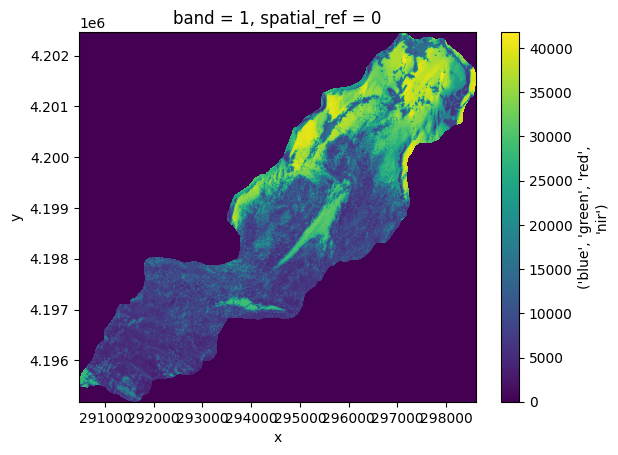

In [13]:
ref_file = rxr.open_rasterio(ref_file)
mask = ref_file.values
mask = np.sum(mask,axis=0)
ref_file = ref_file.isel(band=0)
ref_file.values = mask
ref_file.plot()

In [14]:
# function for classifying snow cover using "model"
def run_sca_prediction_band_selfClassify(f_raster, file_out, model,saveData,ref_file,mask):
        
    ds = rxr.open_rasterio(f_raster)
    ds = ds.rio.reproject_match(ref_file)
    arr = ds.values
    arr_sum = np.sum(arr,axis=0)
    
    print("Image dimension:".format(), arr.shape)  # 
    X_img = pd.DataFrame(arr.reshape([4,-1]).T)
    X_img.columns = ['b','g','r','nir']
    X_img
    y_img = model.predict(X_img)
    
    out_img = pd.DataFrame()
    out_img['label'] = y_img
    
    # Reshape our classification map
    img_prediction = out_img['label'].to_numpy().reshape(arr[0,:, :].shape)
    # put "no-data" classifications in the cells that are just cut off from the obs
    img_prediction[(arr_sum == 0) & (mask > 0)] = 2
    print(img_prediction.shape)
    if saveData:
        ds_save = ref_file
        ds_save.attrs['long_name'] = ('classification')
        ds_save.values = img_prediction
        ds_save.rio.to_raster(file_out)
            
    return img_prediction

In [ ]:
for dCount,direcc in enumerate(subdirecs):
    # if dCount not in filtered_scenes:
    if direcc.split('/')[-1] not in filtered_scenes:
        fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        
        outfile_0 = fname.split('/')[-1].split('_')
        outfile = processed_direc+outfile_0[0]+'_'+outfile_0[1]+'_SCA.tif'
        print(outfile)
            
        classified = run_sca_prediction_band_selfClassify(fname,outfile,model,saveData,ref_file,mask)

        # process the image and plot the image versus the snow cover map for visual inspection
        rgb_image = rxr.open_rasterio(fname)
        _,_,_,_,rgb_image = calc_rgb(rgb_image)
        fg,ax = plt.subplots(1,2)
        ax = np.ravel(ax)
        ax[0].imshow(rgb_image,cmap='gray')
        ax[1].imshow(classified,vmin=0,vmax=2,interpolation='none')
        ax[0].set_title(outfile_0[0])
        ax[0].set_xticks([])
        ax[1].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_yticks([])

    # if dCount == 2:
    #     break

# FOR COMPOSITE MODEL

In [5]:
# # This works when you are clipping to the basin shapefile
# #For open and canopy cover model
# Create basin shapefile
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
# BS = '/home/etboud/projects/snow_mapping/Emma/budd_rectangle_modis_extent_4326_b200.geojson'
basin = gpd.read_file(BS)
basin = basin.to_crs('EPSG:32611')

# canopy height model
# CHM = '/home/etboud/projects/data/CHM/USCATB20140827_chm_3p0m.tif'
# chm_mask, mean, max, fcan = create_binary_chm(CHM, basin)


# ref_file = rxr.open_rasterio(ref_file).rio.clip(basin.geometry)
# open_ref = ref_file.copy()
# open_ref.values = np.where(chm_mask[0], open_ref, 0)
# canop_ref = ref_file - open_ref
# canop_ref.attrs = open_ref.attrs
# canop_ref.rio.set_nodata(0)


# open_mask = open_ref.values

# open_mask = np.sum(open_mask, axis=0)
# open_ref = open_ref.isel(band=0)
# open_ref.values = open_mask
# # Create a canopy reference where 0 replaces open

# canop_mask = canop_ref.values
# canop_mask = np.sum(canop_mask, axis=0)
# canop_ref = canop_ref.isel(band=0)
# canop_ref.values = canop_mask


In [6]:

canopy_tif = f'/home/etboud/projects/data/masks/4b_15img_ndvi_30_85_{name}_notclipped.tif'
#canopy_tif = '/home/etboud/projects/snow_mapping/Emma/4b_15img_ndvi_45_85_BUDD_rec_notclipped.tif'

canopy = rxr.open_rasterio(canopy_tif)
test_file = rxr.open_rasterio(ref_file)
mask = test_file.values
mask = np.sum(mask,axis=0)
test_file = test_file.isel(band=0)
test_file.values = mask

test_file.values = np.where(test_file.values > 0, 1, np.nan)
test_file.values = np.where(canopy[0].values > 0, 0, test_file.values)
chm_mask = test_file

ref_file = rxr.open_rasterio(ref_file)
open_ref = ref_file.copy()
open_ref.values = np.where(chm_mask, open_ref, 0)
canop_ref = ref_file - open_ref
canop_ref.attrs = open_ref.attrs
canop_ref.rio.set_nodata(0)


open_mask = open_ref.values
open_mask = np.sum(open_mask, axis=0)
open_ref = open_ref.isel(band=0)
open_ref.values = open_mask
# Create a canopy reference where 0 replaces open

canop_mask = canop_ref.values
canop_mask = np.sum(canop_mask, axis=0)
canop_ref = canop_ref.isel(band=0)
canop_ref.values = canop_mask

canopy_pixels = canop_ref.copy()
canopy_pixels.values = np.where(canop_ref > 0, 1, np.nan)
open_pixels = open_ref.copy()
open_pixels.values = np.where(open_ref > 0, 1, np.nan)

In [7]:
# function for classifying snow cover using "model"
def run_sca_prediction_composite(f_raster, file_out, model,saveData,ref_file,mask):
        
    ds = rxr.open_rasterio(f_raster)
    ds = ds.rio.reproject_match(ref_file)
    
    zeros = np.zeros((1, ds.shape[1], ds.shape[2]))
    mask_bool = mask > 0
    mask_num = ds.where(mask_bool)
    clipped_ds = mask_num + zeros
    arr = clipped_ds.values
    # arr = ds.values
    arr_sum = np.sum(arr,axis=0)
    
    print("Image dimension:".format(), arr.shape)  # 
    X_img = pd.DataFrame(arr.reshape([4,-1]).T)
    X_img.columns = ['b','g','r','nir']
    X_img
    y_img = model.predict(X_img)
    
    out_img = pd.DataFrame()
    out_img['label'] = y_img
    
    # Reshape our classification map
    img_prediction = out_img['label'].to_numpy().reshape(arr[0,:, :].shape)
    # put "no-data" classifications in the cells that are just cut off from the obs
    img_prediction[(arr_sum == 0) & (mask > 0)] = 2

            
    return img_prediction

In [8]:
# ref_file = f'/data0/images/planet/emma/planet/{name}/' + '20230423_175100_99_242e/a514a5df-5610-45c4-8498-a774361cb492/PSScene/20230423_175100_99_242e_3B_AnalyticMS_SR_clip.tif' # BUDD
ref_file = data_direc+'20230609_175435_13_242e/25d3618d-2f37-4c9e-8d67-c10e9d477081/PSScene/20230609_175435_13_242e_3B_AnalyticMS_SR_clip.tif' # DLNY
# ref_file  = data_direc + '20220403_174654_26_2451/68f7d4a5-cb41-4b0b-b0bb-1ce016f66730/PSScene/20220403_174654_26_2451_3B_AnalyticMS_SR_clip.tif' # BUDD rec
# ref_file = data_direc + '20220609_173032_58_249d/6f0dba90-e90f-490d-936d-28c482343d1e/PSScene/20220609_173032_58_249d_3B_AnalyticMS_SR_clip.tif' #COPP
reference_file = rxr.open_rasterio(ref_file)
mask = reference_file.values
mask = np.sum(mask,axis=0)
reference_file = reference_file.isel(band=0)
reference_file.values = mask

/home/etboud/projects/data/temp/DLNY/composite/20220327_180948_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220330_174957_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220330_175448_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220401_182119_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220401_182251_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220403_174651_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220405_174728_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/comp

/tmp/ipykernel_3739142/2696829631.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fg,ax = plt.subplots(1,4)


/home/etboud/projects/data/temp/DLNY/composite/20220504_183833_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220506_182128_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220512_174849_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220514_175051_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220516_174736_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220519_174722_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/composite/20220519_181733_SCA.tif
Image dimension: (4, 2426, 2716)
Image dimension: (4, 2426, 2716)
/home/etboud/projects/data/temp/DLNY/comp

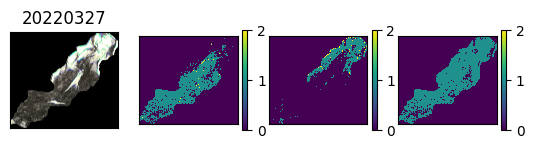

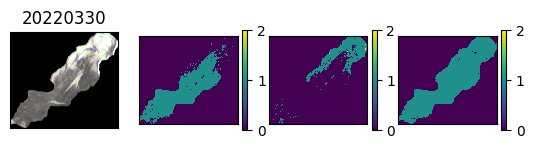

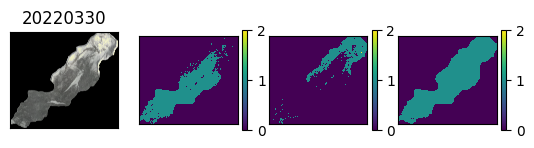

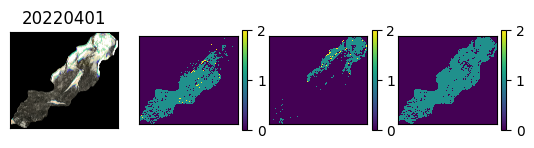

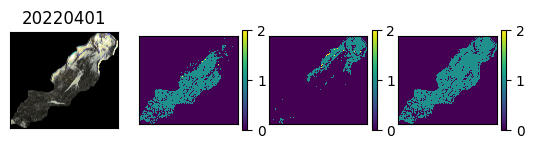

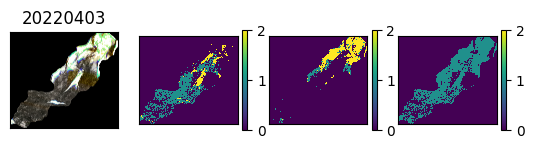

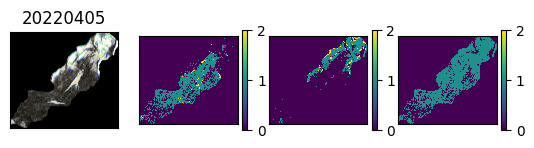

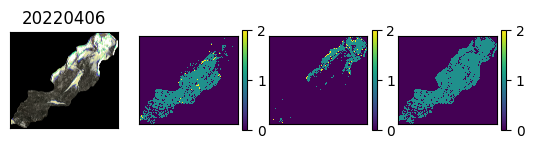

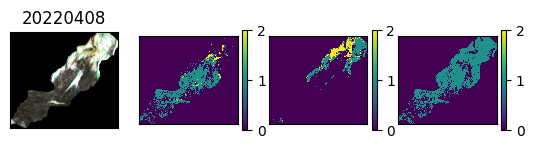

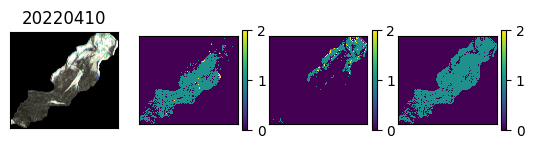

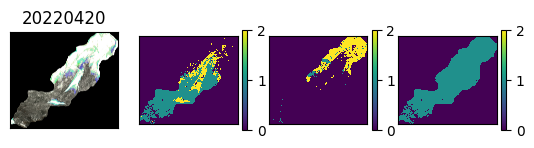

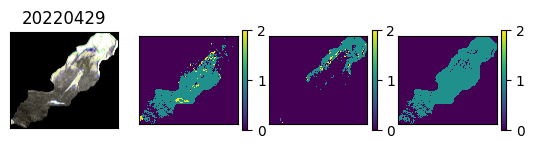

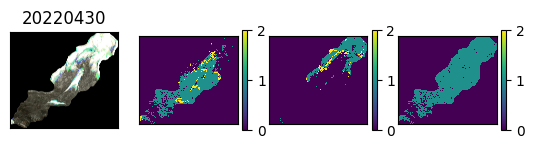

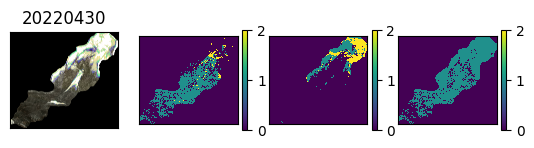

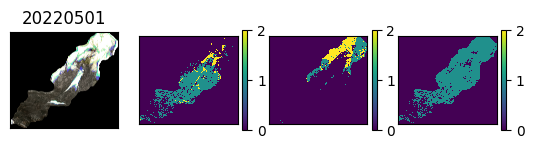

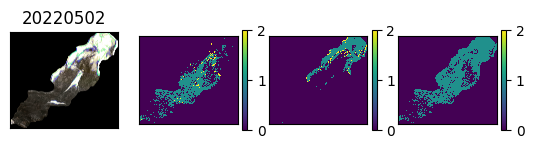

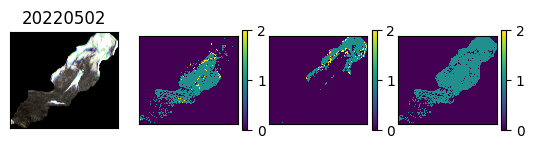

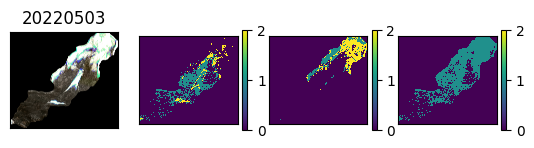

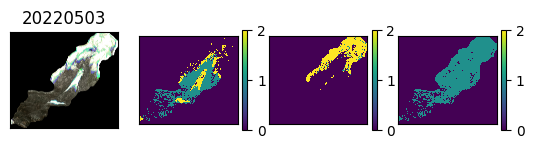

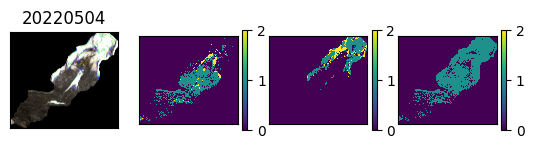

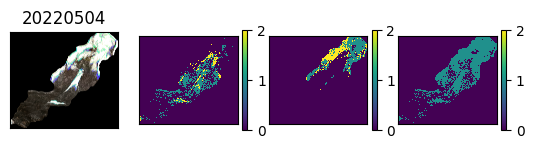

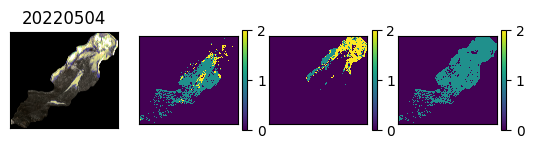

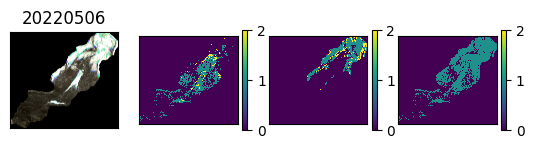

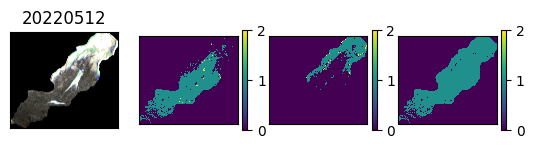

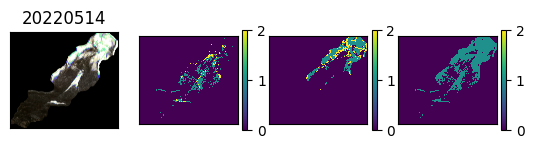

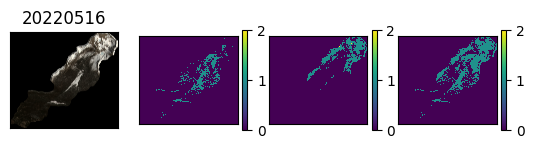

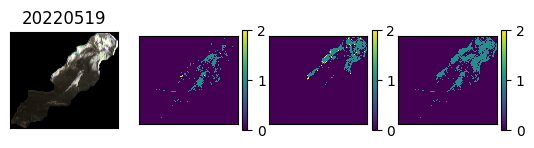

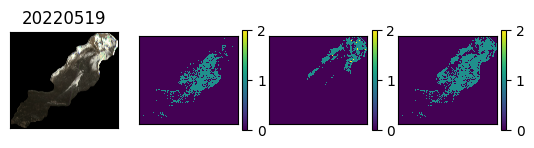

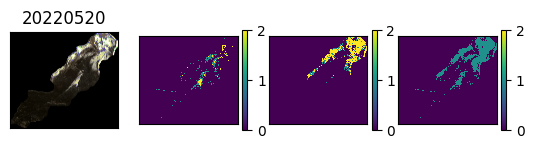

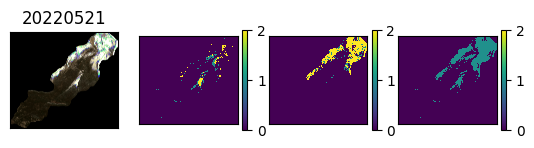

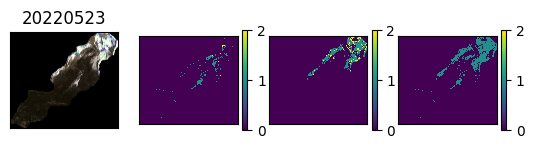

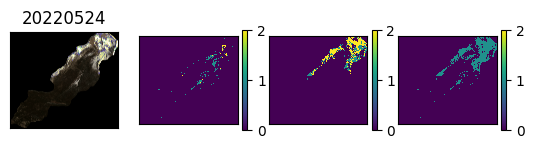

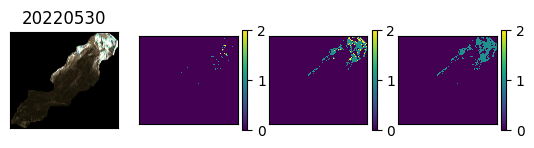

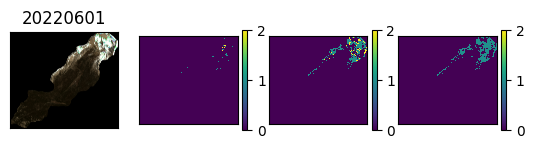

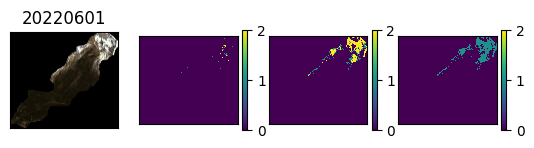

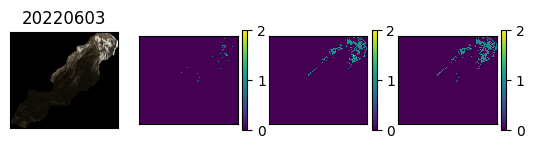

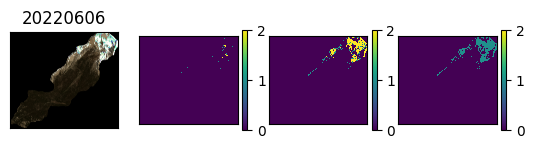

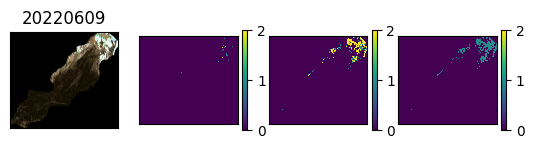

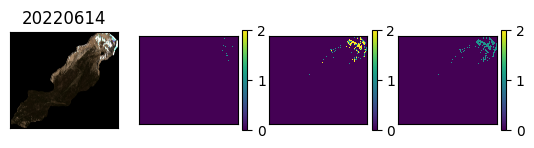

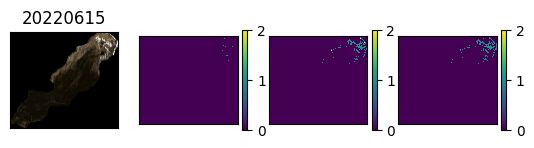

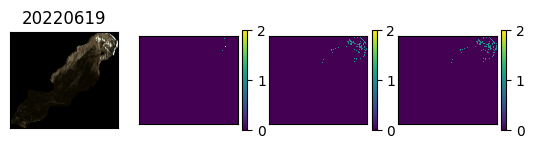

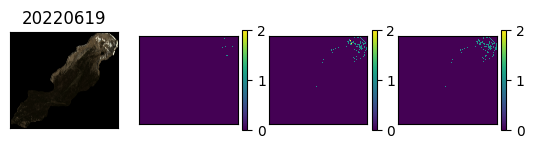

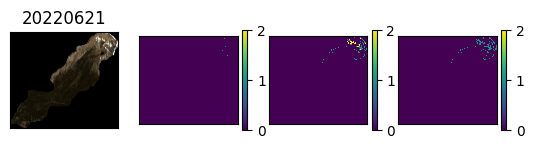

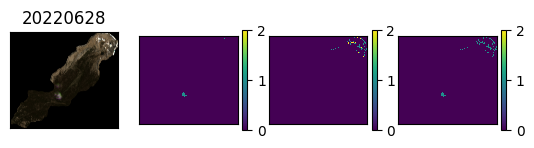

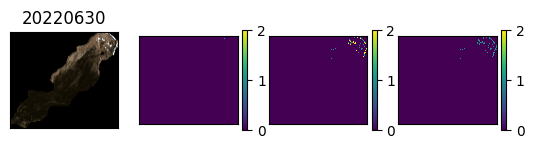

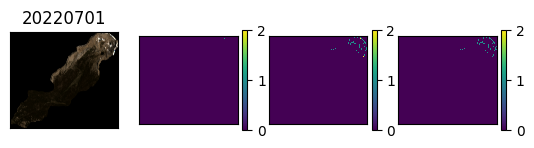

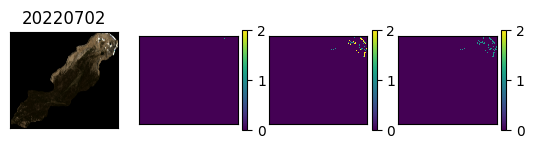

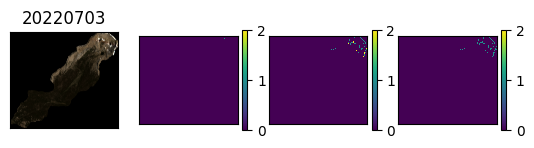

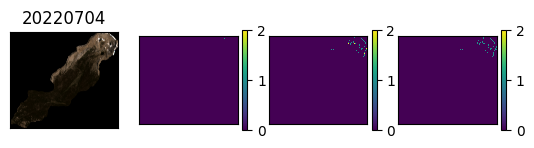

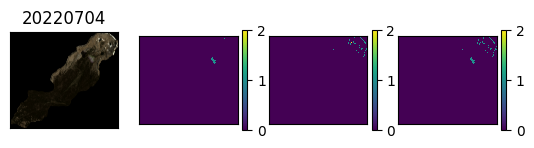

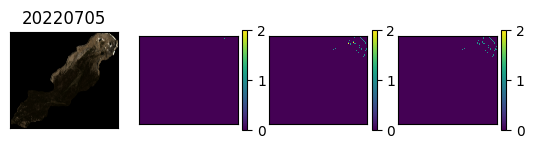

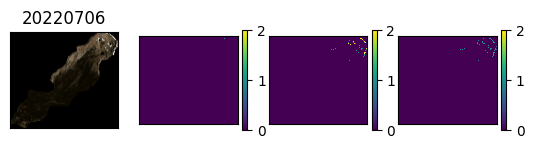

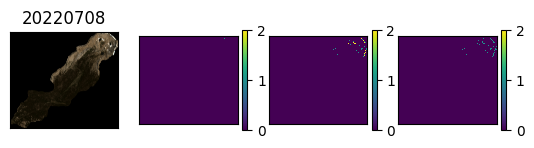

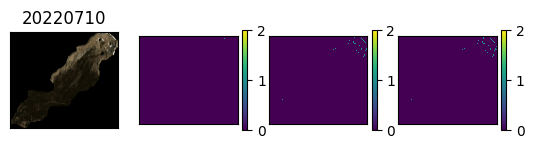

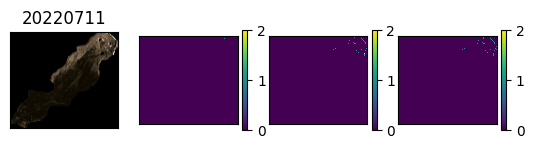

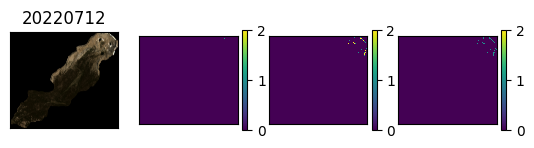

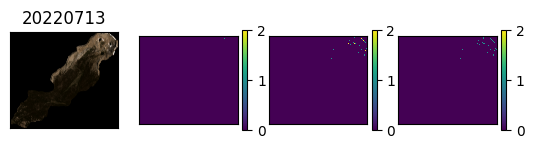

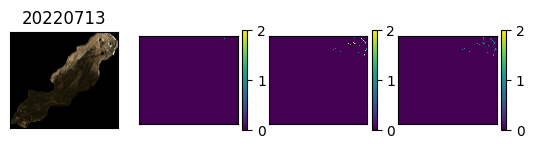

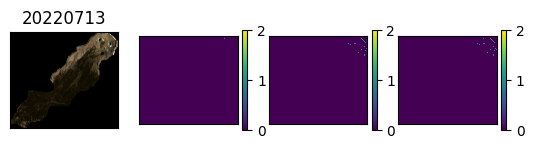

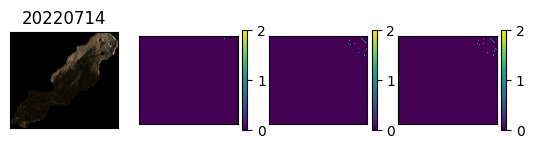

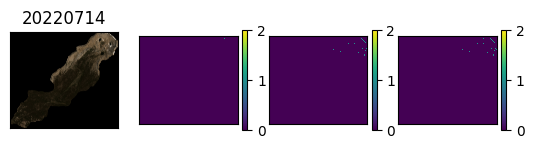

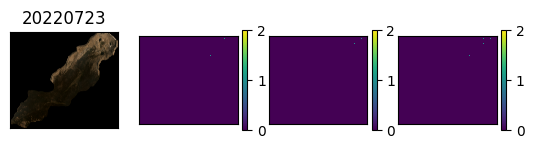

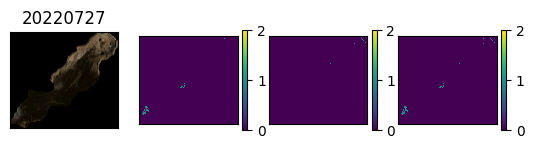

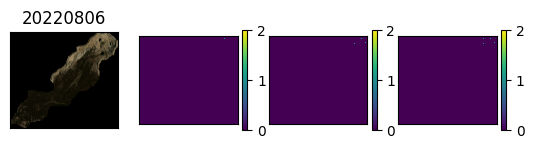

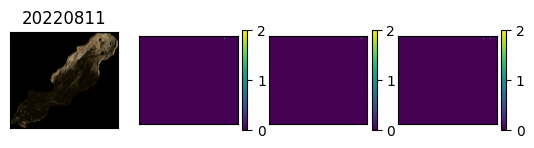

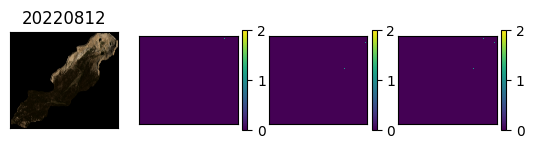

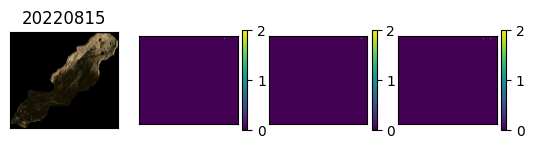

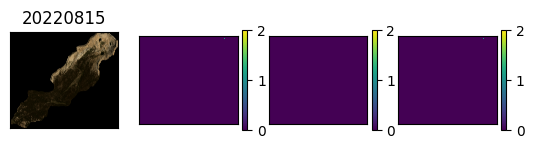

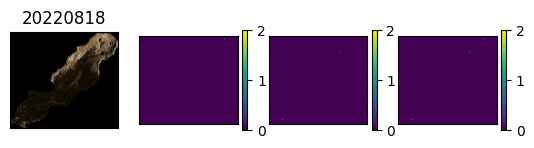

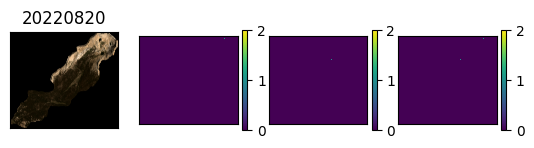

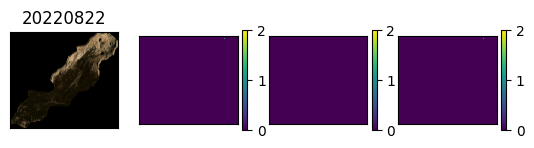

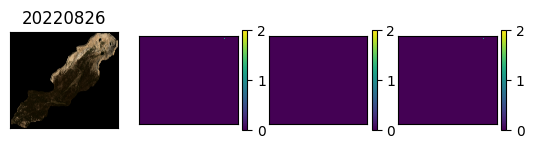

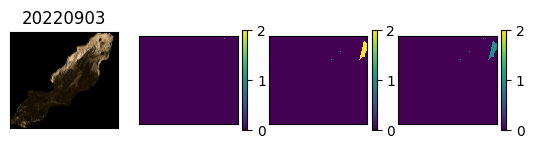

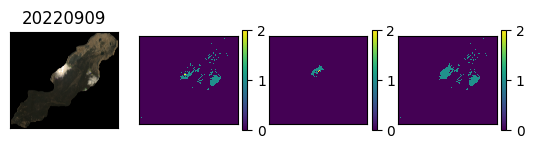

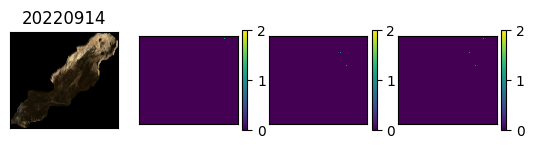

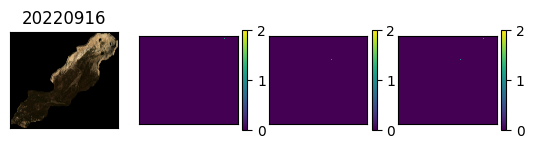

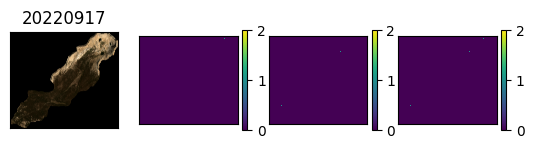

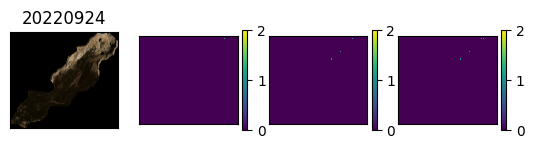

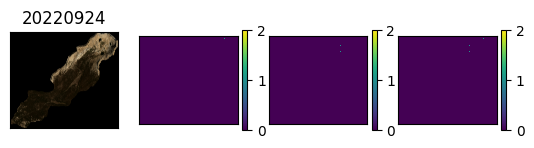

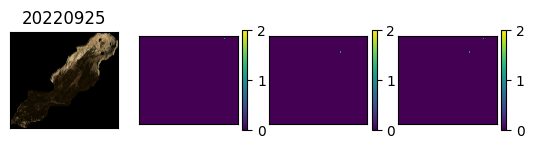

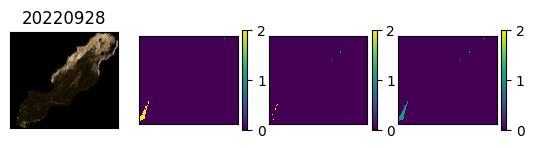

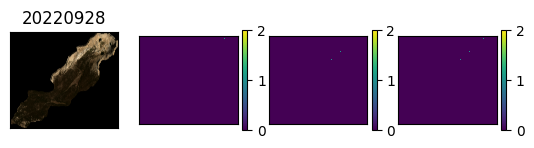

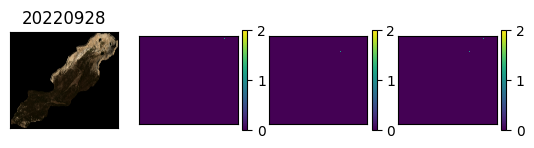

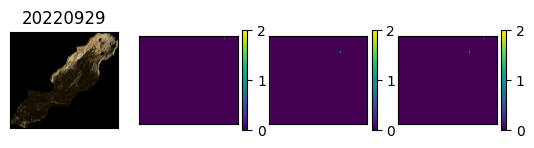

In [9]:
for dCount, direcc in list(enumerate(subdirecs)):
    if direcc.split('/')[-1] not in filtered_scenes:
        fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        
        outfile_0 = fname.split('/')[-1].split('_')
        outfile = processed_direc+outfile_0[0]+'_'+outfile_0[1]+'_SCA.tif'
        print(outfile)
            
        classified_can = run_sca_prediction_composite(fname,outfile,model_can,saveData,canop_ref,canop_mask)
        #only classified cna wehre canopy pixels are present
        classified_can = np.where(canopy_pixels > 0, classified_can, 0)
        classified_open = run_sca_prediction_composite(fname,outfile,model_open,saveData,open_ref,open_mask)
        #only classified where open pixels are present
        classified_open = np.where(open_pixels > 0, classified_open, 0)

        classified = classified_can + classified_open
        
        # classified = np.where(classified == 1, 0, classified)
        classified = np.where(classified == 2, 1, classified)
        if saveData:
            # Save the classification result
            ds_save = reference_file
            ds_save.attrs['long_name'] = ('classification')
            ds_save.values = classified
            ds_save.rio.to_raster(outfile)
        
        # process the image and plot the image versus the snow cover map for visual inspection
        rgb_image = rxr.open_rasterio(fname)
        _,_,_,_,rgb_image = calc_rgb(rgb_image)
        fg,ax = plt.subplots(1,4)
        ax = np.ravel(ax)
        ax[0].imshow(rgb_image,cmap='gray')
        ax[1].imshow(classified_can,vmin=0,vmax=2,interpolation='none')
        ax[2].imshow(classified_open,vmin=0,vmax=2, interpolation='none')
        ax[3].imshow(classified,vmin=0,vmax=2, interpolation='none')
        #colorbar
        plt.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical', fraction=0.046, pad=0.04)
        plt.colorbar(ax[2].images[0], ax=ax[2], orientation='vertical', fraction=0.046, pad=0.04)
        plt.colorbar(ax[3].images[0], ax=ax[3], orientation='vertical', fraction=0.046, pad=0.04)
        ax[0].set_title(outfile_0[0])
        ax[0].set_xticks([])
        ax[1].set_xticks([])
        ax[2].set_xticks([])
        ax[3].set_xticks([])
        ax[0].set_yticks([])
        ax[1].set_yticks([])
        ax[2].set_yticks([])
        ax[3].set_yticks([])

In [ ]:
# for dCount,direcc in enumerate(subdirecs):
#     # if dCount not in filtered_scenes:
#     if direcc.split('/')[-1] not in filtered_scenes:
#         fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        
#         outfile_0 = fname.split('/')[-1].split('_')
#         outfile = processed_direc+outfile_0[0]+'_'+outfile_0[1]+'_SCA.tif'
#         print(outfile)
            
#         classified = run_sca_prediction_band_selfClassify(fname,outfile,model,saveData,ref_file,mask)

#         # process the image and plot the image versus the snow cover map for visual inspection
#         rgb_image = rxr.open_rasterio(fname)
#         _,_,_,_,rgb_image = calc_rgb(rgb_image)
#         fg,ax = plt.subplots(1,2)
#         ax = np.ravel(ax)
#         ax[0].imshow(rgb_image,cmap='gray')
#         ax[1].imshow(classified,vmin=0,vmax=2,interpolation='none')
#         ax[0].set_title(outfile_0[0])
#         ax[0].set_xticks([])
#         ax[1].set_xticks([])
#         ax[0].set_yticks([])
#         ax[1].set_yticks([])

#     # if dCount == 2:
    #     break

In [ ]:
# checking the output
# dirr = '/home/etboud/projects/data/planet/processed_SCA/'

# for d in glob.glob(dirr + str(focus_year) + '*'):
#     cl= rxr.open_rasterio(d)
#     #print(d)
#     fig, ax = plt.subplots()
#     ax.imshow(cl[0],vmin=0,vmax=2,interpolation='none')
#     ax.set_title(d.split('/')[-1])